# Trabajo Final
<br/>

## Curso de Especialización en Inteligencia Artificial
## Inteligencia Artificial Embebida
<br/>

### Autor: Maximiliano Torti
### Fecha: 17/01/21
<br/>

In [52]:
import pickle as pkl
import pandas as pd
import numpy as np
from scipy import stats
from scipy import fftpack
from scipy.signal import buttord
from scipy.signal import butter
from scipy.signal import lfilter
import wave

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (20, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 20

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)

## Identificacion de eventos

Primero cargamos los archivos de audio que utilizaremos para identificar eventos

In [53]:
path = './Audios/Detección de eventos masticatorios/'

In [54]:
def load_file(file_path, filename, adq_freq=22050):
    # Read file to get buffer                                                                                               
    ifile = wave.open(file_path+filename+".wav")
    samples = ifile.getnframes()
    audio = ifile.readframes(samples)

    # Convert buffer to float32 using NumPy                                                                                 
    audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
    audio_as_np_float32 = audio_as_np_int16.astype(np.float32)

    # Normalize float32 array so that values are between -1.0 and +1.0                                                      
    max_int16 = 2**15
    audio_normalized = audio_as_np_float32 / max_int16
    timestamp_audio = np.arange(audio_normalized.shape[0])/adq_freq
    df_marks = pd.read_csv(file_path+filename+".txt", sep="\t", header=None, names= ['tstart','tend','class'])
    
    return timestamp_audio,audio_normalized, df_marks

In [55]:
t0, audio0, tmarks0 = load_file(path,"recording_01")
t1, audio1, tmarks1 = load_file(path,"recording_51")
t2, audio2, tmarks2 = load_file(path,"recording_52")

Graficamos uno de los audios para observar las formas de onda. Superpuesto se grafican con sombreado los eventos, obtenidos de los archivos de marcas temporales

In [56]:
def plot_audio(t, audio, tmarks, tpred=None):
    plt.figure(figsize=(20, 10))
    plt.plot(t,audio,color='blue')
    plt.xlabel("Tiempo[s]")
    for idx in range(len(tmarks)):
        plt.axvspan(tmarks['tstart'].iloc[idx], tmarks['tend'].iloc[idx], color='orange', alpha=0.2, lw=0)
    if tpred is not None:
        for idx in range(len(tpred)):
            plt.axvspan(tpred['tstart'].iloc[idx], tpred['tend'].iloc[idx], color='green', alpha=0.1, lw=0)
    plt.ylabel("Amplitud normalizada")
    plt.title("Forma de onda")
    plt.grid(True)
    plt.show()

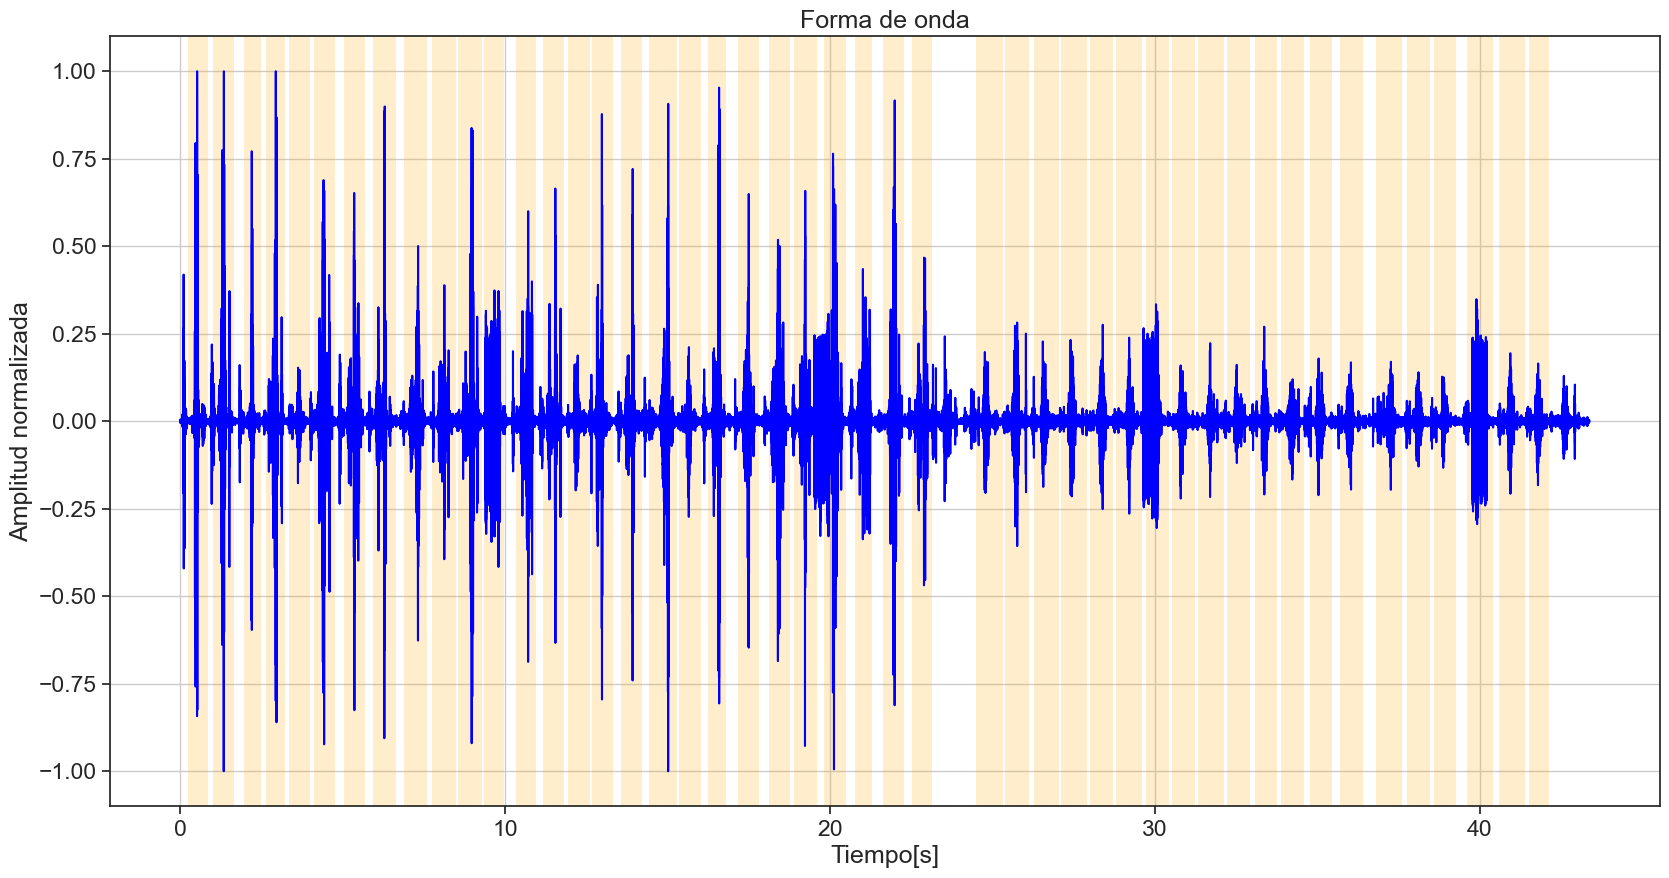

In [57]:
plot_audio(t0,audio0,tmarks0)

Para mayor información, graficamos la transformada de fourier

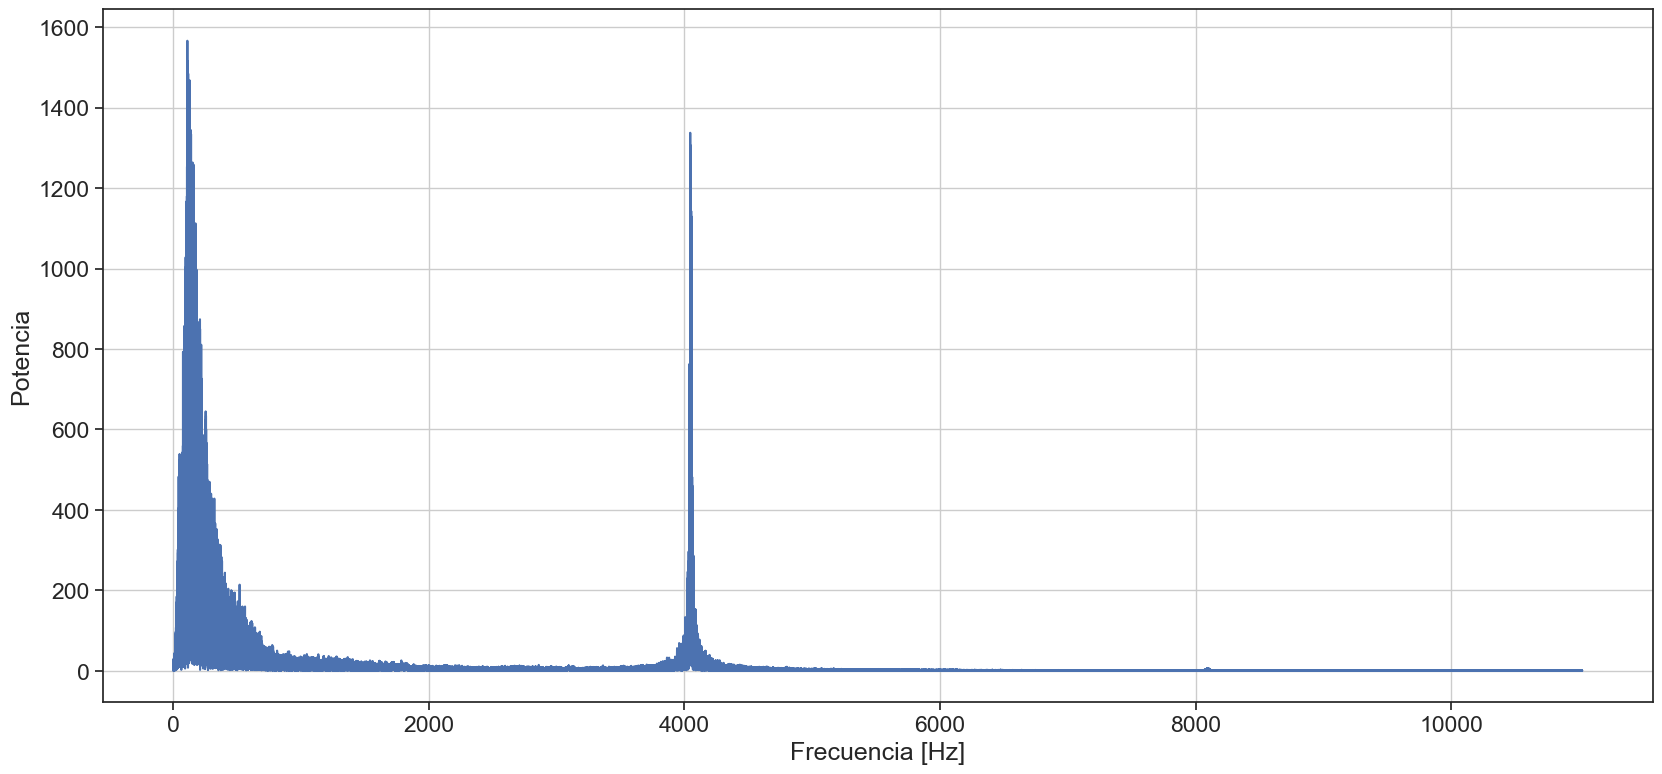

In [58]:
def plot_fft(audio,freq_adq=22050):
    sample_freq = fftpack.fftfreq(len(audio),d=1/freq_adq) 
    sig_fft = fftpack.fft(audio)
    idxs = np.where(sample_freq >= 0)
    freqs = sample_freq[idxs]
    power = np.abs(sig_fft)[idxs]
    plt.plot(freqs, power)
    plt.grid(True)
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Potencia')
    plt.show()  

plot_fft(audio0)

Se observa:
- Ruido de 4KHz, este ruido se corresponde con una marca de tiempo utilizada para sincronismo. Es necesario filtrar
- La mayor parte de la información se encuentra en la banda de 0 a 2KHz.
    
Por estas razones, aplicamos un filtro pasabajo con fc = 2KHz

In [59]:
def my_filter(audio, wp=2000, ws=2500, gpass=3, gstop=40, freq_adq=22050):
    order, wn = buttord(wp=wp, ws=ws, gpass=gpass, gstop=gstop, analog=False, fs=freq_adq)
    b, a = butter(order, wn, btype='lowpass', analog=False, fs=freq_adq)
    return lfilter(b, a, audio)

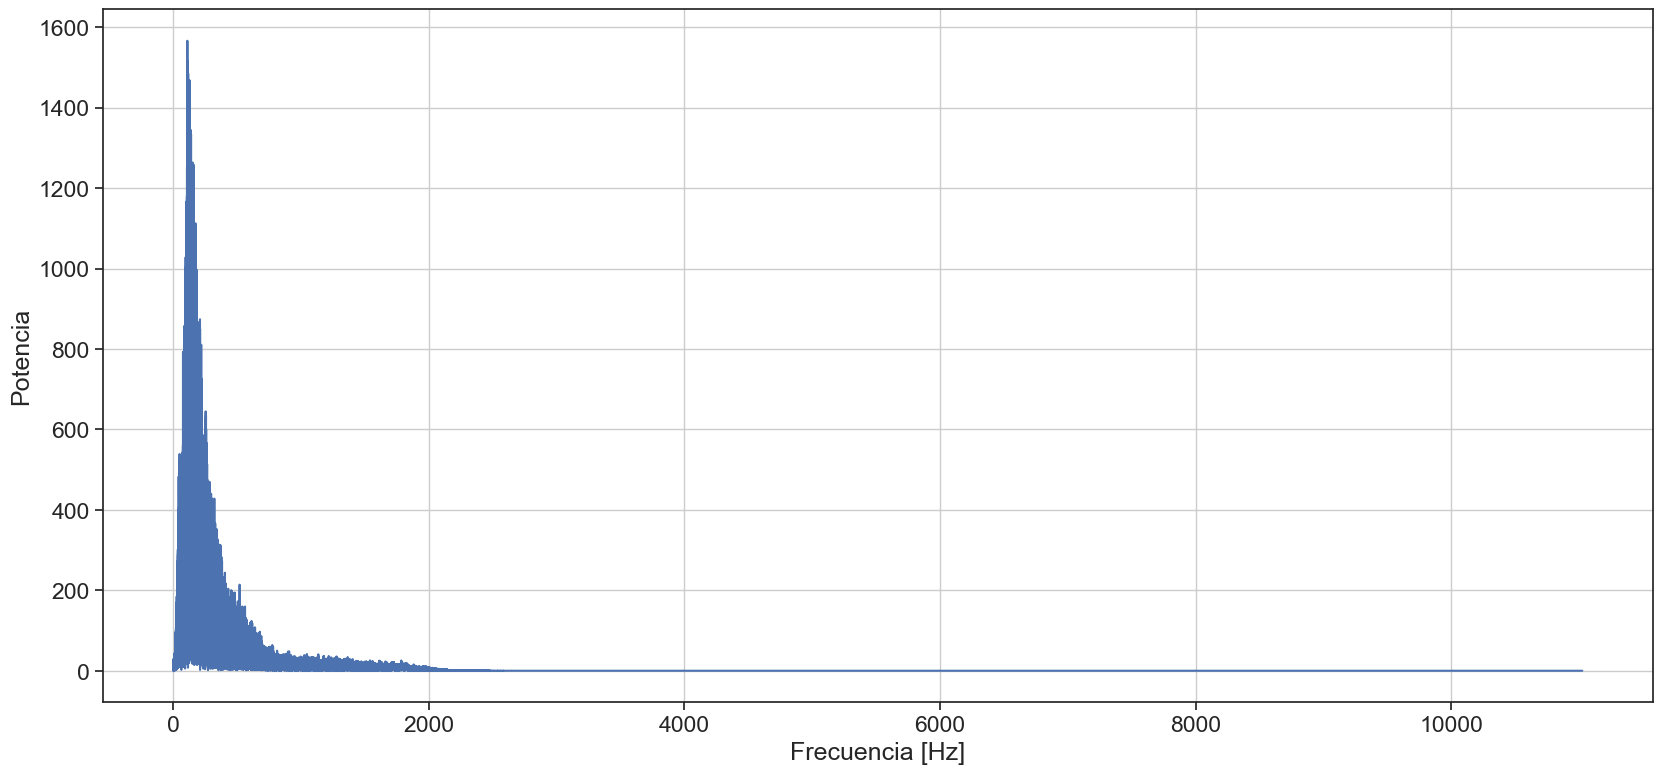

In [60]:
audio0_filter_2k = my_filter(audio0)
plot_fft(audio0_filter_2k)

In [61]:
audio1_filter_2k = my_filter(audio1)
audio2_filter_2k = my_filter(audio2)

Graficamos nuevamente la señal (ahora filtrada) junto con las marcas temporales

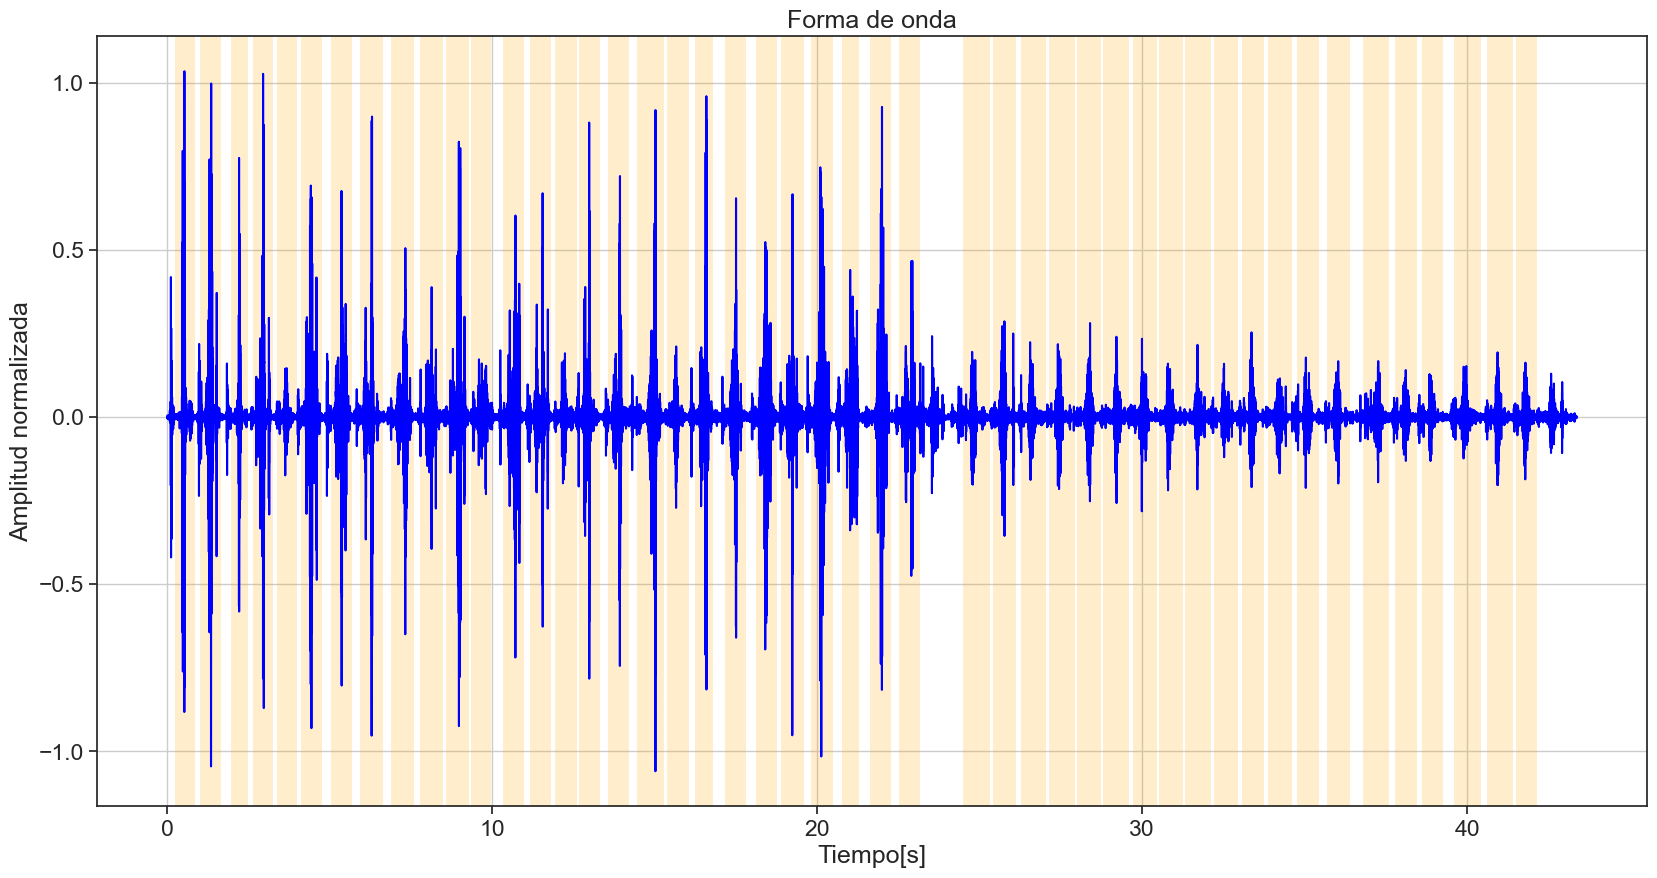

In [62]:
plot_audio(t0,audio0_filter_2k,tmarks0)

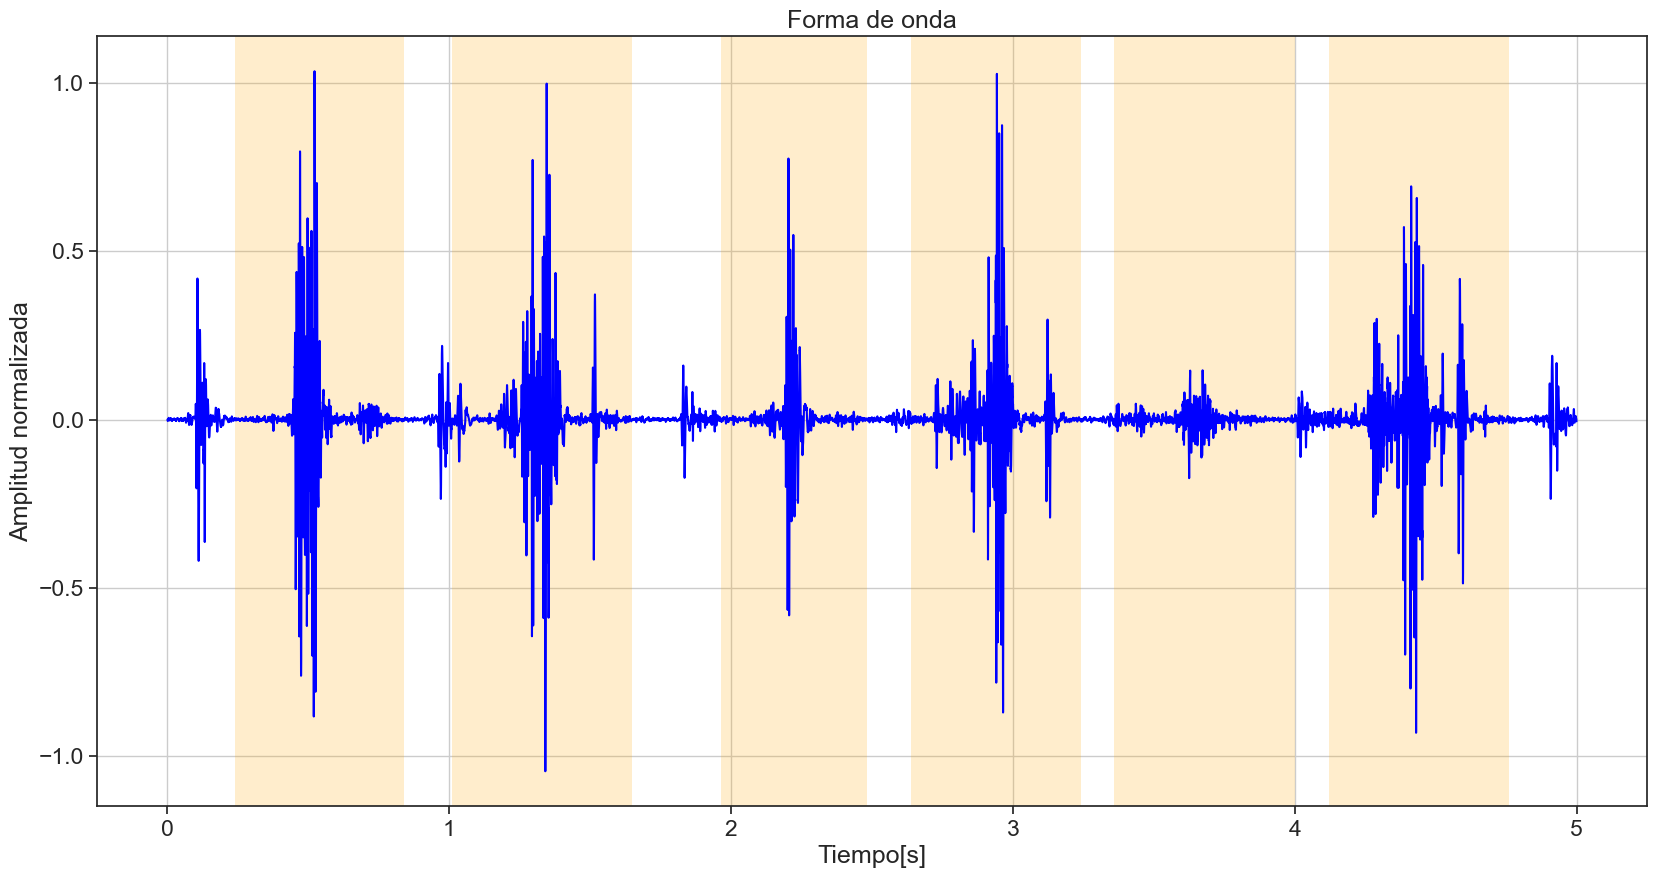

In [63]:
plot_audio(t0[:110250],audio0_filter_2k[:110250],tmarks0[:6])

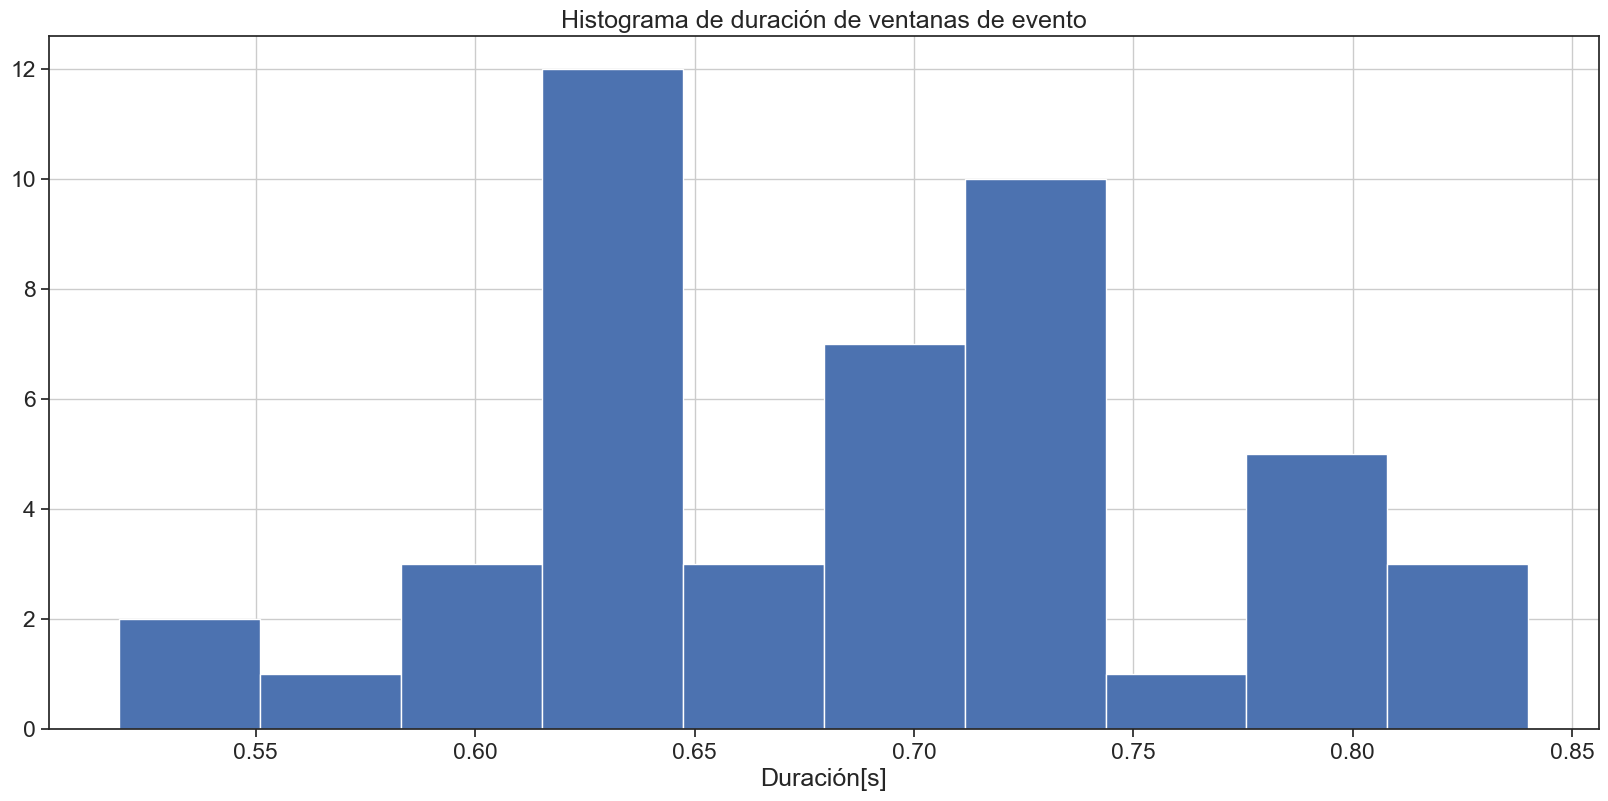

In [64]:
plt.hist(tmarks0['tend']-tmarks0['tstart'],color='b')
plt.title("Histograma de duración de ventanas de evento")
plt.xlabel("Duración[s]")
plt.grid(True)
plt.show()

Una vez filtrado el ruido, nos propopnemos a crear el detector. A partir de las imagenes anteriores, podemos plantear como detector de eventos un detector de umbral junto a un buffer de memoria. De esta manera tendremos que ajustar 4 parámetros:
- trigger_thd: amplitud a partir de la cual comenzamos a detectar evento (tomaremos valor absoluto de la señal).
- t_pre: tiempo hacia atrás de la detección que queremos incluir en la ventana.
- t_post: tiempo luego de la detección que queremos incluir en la ventana.
- retrigger: variable booleana que nos indicara si un disparo ("trigger) dentro de una ventana abierta abre una nueva ventana o es filtrado.

Se encontrara el mejor juego de parámetros utilizando "grid search" y como métrica de evaluación se utiliza el coeficiente de dice (equivalente a F1-Score para intersecciones/uniones de conjuntos).

In [65]:
def event_detect(audio, thd, t_pre, t_post, retrigger):
    detection = np.zeros(len(audio))
    if retrigger:
        idx=np.nonzero(audio>thd)[0]
        safe_start = idx+int(np.ceil(t_pre))
        safe_start[np.argwhere(safe_start<0)]=0
        safe_end = idx+int(np.floor(t_post))
        safe_end[np.argwhere(safe_end>len(audio))]=len(audio)
        for i in range(len(safe_start)):
            detection[safe_start[i]:safe_end[i]]=1
    else:
        idx = 0
        while idx<len(audio):
            if abs(audio[idx])>=thd:
                safe_start= int(np.ceil(max(0,idx+t_pre)))
                safe_end = int(np.floor(min(len(audio),max(idx+t_post,idx))))
                detection[safe_start:safe_end]=1
                if not(retrigger):
                    idx = safe_end
            idx = idx+1
    return detection

In [66]:
def dice_coef(y_true, y_pred):
    return np.sum(y_true*y_pred)*2.0 / (np.sum(y_true) + np.sum(y_pred))

In [67]:
def tmark_to_event_detect(tmarks, final_len, freq=22050):
    detection = np.zeros(final_len)
    for idx in range(len(tmarks)):
        start = int(np.ceil(tmarks['tstart'].iloc[idx]*freq))
        end = int(np.floor(tmarks['tend'].iloc[idx]*freq))
        detection[start:end]=1
    return detection

In [68]:
event0_true = tmark_to_event_detect(tmarks0, len(audio0_filter_2k))
event1_true = tmark_to_event_detect(tmarks1, len(audio1_filter_2k))

In [ ]:
freq=22050
max_window=max(max(tmarks0['tend']-tmarks0['tstart'])*freq,max(tmarks1['tend']-tmarks1['tstart'])*freq)
thd_opt = np.linspace(0.1,0.5,100)
t_pre_opt = np.linspace(-max_window,0,100)
t_post_opt = np.linspace(0,max_window,100)
retrigger_opt = [False,True]

best_params = []
best_dice = 0

for thd in thd_opt:
    for t_pre in t_pre_opt:
        for t_post in t_post_opt:
            for retrigger in retrigger_opt:
                event0_pred = event_detect(audio0_filter_2k, thd, t_pre, t_post, retrigger)
                event1_pred = event_detect(audio1_filter_2k, thd, t_pre, t_post, retrigger)
                new_dice = dice_coef(np.concatenate((event0_true,event1_true)),np.concatenate((event0_pred,event1_pred))) 
                if new_dice > best_dice:
                    best_dice = new_dice
                    best_params = [thd, t_pre, t_post, retrigger]
                    
print("Mejor coef dice obtenido:" ,best_dice)
print("Mejores parametros: ", best_params)

In [20]:
# Valido con audio2
event_true = tmark_to_event_detect(tmarks2, len(audio2_filter_2k))
print("Referencia coef dice deteccion continua:" ,dice_coef(event_true,np.ones(len(event_true))))
event_pred = event_detect(audio2_filter_2k, 0.1, -7056, 9408, False)
print("Coeficiente dice prediccion: ", dice_coef(event_true,event_pred))

Referencia coef dice deteccion continua: 0.8612828952436713
Coeficiente dice prediccion:  0.8866259697316546


### Grafica de resultados

In [24]:
def event_detect_to_tmark(event_detect, freq=22050):
    event = False
    tstart = 0
    tend = 0
    tmarks = []
    for idx in range(len(event_detect)):
        if event:
            if not(event_detect[idx]):
                tend = idx / freq
                tmarks.append([tstart,tend])
                event = False
        else:
            if event_detect[idx]:
                tstart = idx / freq
                event = True
    return pd.DataFrame(tmarks,columns=['tstart', 'tend'])

In [25]:
tmarks1

,tstart,tend,class
0,0.000000,0.400000,bite
1,1.248732,1.726750,bite
2,2.200469,2.700749,bite
3,3.098206,3.578206,bite
4,4.400938,4.920938,bite
...,...,...,...
90,112.392667,113.152667,chew
91,115.943117,116.849905,chew
92,117.232349,117.927249,chew
93,118.352833,119.220749,chew


In [40]:
event_detect_to_tmark(event_detect(audio1_filter_2k, 0.1, -7203, 16464, False))

,tstart,tend
0,0.000000,3.705669
1,4.278095,6.222540
2,6.300771,11.915918
3,12.441451,13.514785
4,13.567347,20.184354
5,20.265488,22.191837
6,22.198503,25.011338
7,25.533333,35.691383
8,37.270249,39.326032
9,39.391791,42.309705


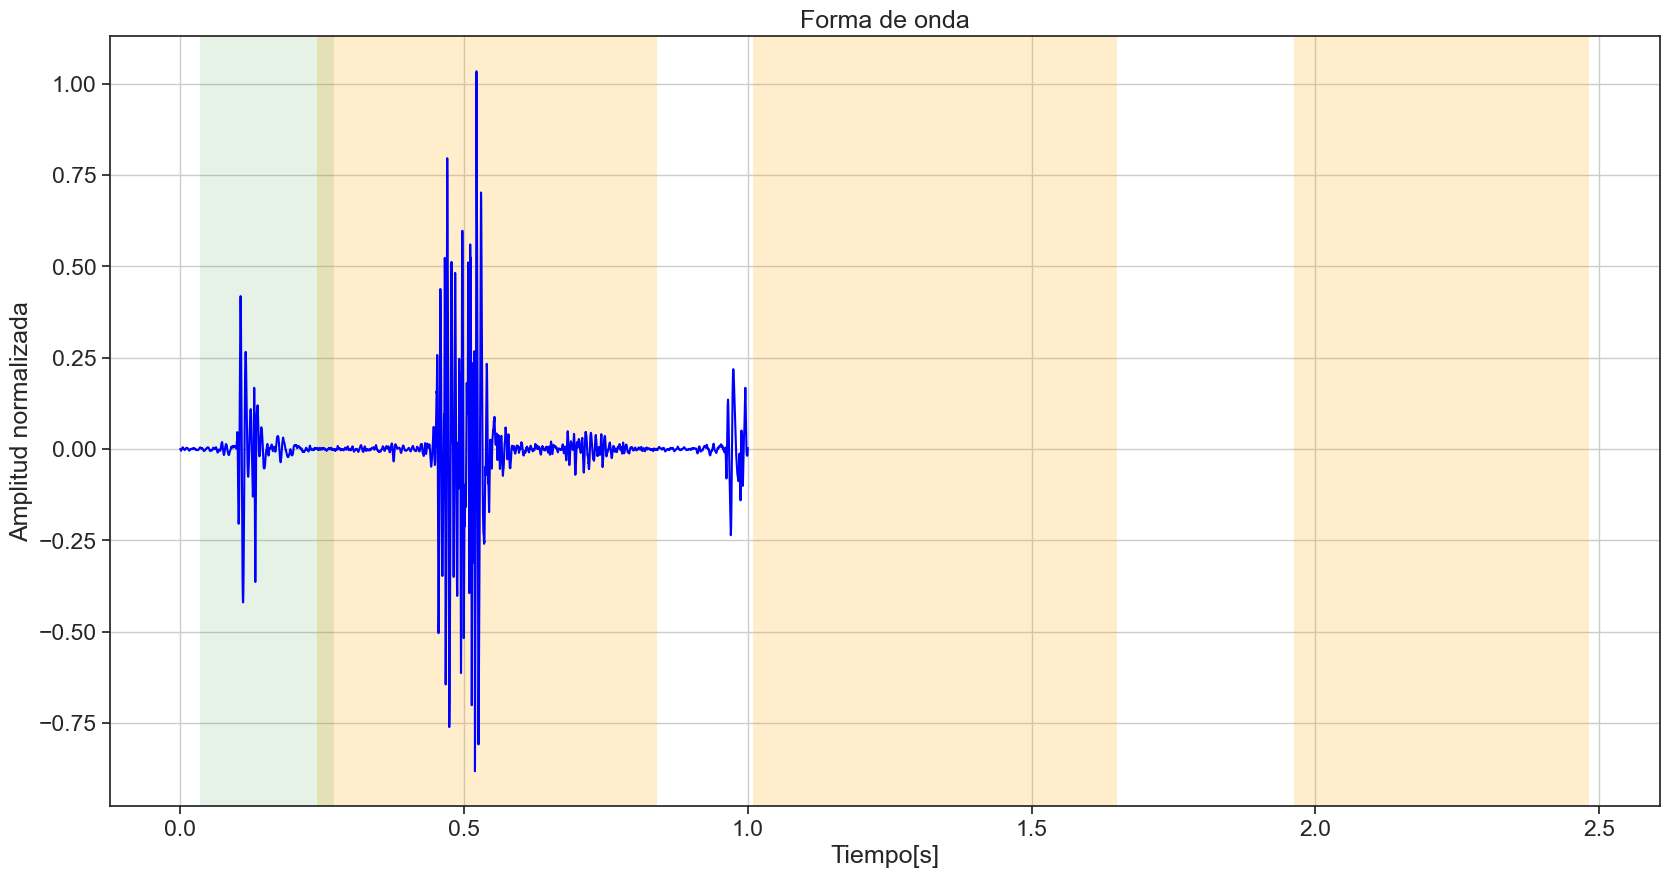

In [51]:
plot_audio(t0[0:22050],
           audio0_filter_2k[0:22050],
           tmarks0[0:3], 
           event_detect_to_tmark(event_detect(audio0_filter_2k, 0.2, -1500, 3700, False))[0:1]
          )

# Carga de metadatos

In [ ]:
detection[len(t0)]

In [ ]:
path = './data/'

file = "recording_52"

## Analisis metadatos

In [ ]:
df_classes.head()

In [ ]:
df_classes['class'].unique()

In [ ]:
fig, ax = plt.subplots(1,figsize=(8,6))
sns.countplot(x='class',data=df_classes)  
ax.set_title('Classes ocurrence')

# Carga de audio

In [ ]:
audio = wavfile.read(path+file+".wav")[1]

In [ ]:
adq_freq= 22050

# Read file to get buffer                                                                                               
ifile = wave.open(path+file+".wav")
samples = ifile.getnframes()
audio = ifile.readframes(samples)

# Convert buffer to float32 using NumPy                                                                                 
audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
audio_as_np_float32 = audio_as_np_int16.astype(np.float32)

# Normalise float32 array so that values are between -1.0 and +1.0                                                      
max_int16 = 2**15
audio_normalised = audio_as_np_float32 / max_int16

t_audio = np.arange(audio_normalised.shape[0])/adq_freq

## Analisis de audio

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(t_audio,audio_normalised,color='blue')
plt.show()

In [ ]:
Audio(audio_normalised, rate=adq_freq)

In [ ]:
colors = {
  "bite": "yellow",
  "chewbite": "orange",
  "chew": 'red'
}

plt.figure(figsize=(30, 15))
plt.plot(t_audio,audio_normalised,color='blue')

for idx in range(len(df_classes)):
    plt.axvspan(df_classes['tstart'].iloc[idx], df_classes['tend'].iloc[idx], color=colors[df_classes['class'].iloc[idx]], 
                alpha=0.6, lw=0, label=df_classes['class'].iloc[idx])
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

# Analisis de chew

In [ ]:
chew_idxs = np.argwhere(np.array(df_classes['class'] =='chew'))

In [ ]:
idx1=int(np.argwhere(t_audio>np.array(df_classes['tstart'].iloc[chew_idxs[0]]))[0])
idx2= int(np.argwhere(t_audio>np.array(df_classes['tend'].iloc[chew_idxs[0]]))[0])

plt.figure(figsize=(20, 10))
plt.plot(t_audio[idx1:idx2],audio_normalised[idx1:idx2],color='blue')
plt.title("Random Chew graph")
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))

idx1=int(np.argwhere(t_audio>np.array(df_classes['tstart'].iloc[chew_idxs[0]]))[0])
idx2= int(np.argwhere(t_audio>np.array(df_classes['tend'].iloc[chew_idxs[0]]))[0])
audio_cut = audio_normalised[idx1:idx2]
N = audio_cut.shape[0]
dt = 1/adq_freq
ft = np.fft.fft(audio_cut) * dt      
freq = np.fft.fftfreq(N, dt)
freq = freq[:int(N/2+1)-1]

plt.plot(freq, np.abs(ft[:int(N/2+1)-1]))

plt.title("Random Chew fourier transform")
plt.show()

In [ ]:
Audio(audio_normalised[idx1:idx2], rate=adq_freq)

In [ ]:
plt.figure(figsize=(20, 10))
for idx in chew_idxs:
    idx1=int(np.argwhere(t_audio>np.array(df_classes['tstart'].iloc[idx]))[0])
    idx2= int(np.argwhere(t_audio>np.array(df_classes['tend'].iloc[idx]))[0])
    plt.plot(np.arange(idx2-idx1)/adq_freq,audio_normalised[idx1:idx2],color='blue', alpha=0.2)
plt.title("Chews Overlapped")
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
for idx in chew_idxs:
    
    idx1=int(np.argwhere(t_audio>np.array(df_classes['tstart'].iloc[idx]))[0])
    idx2= int(np.argwhere(t_audio>np.array(df_classes['tend'].iloc[idx]))[0])
    audio_cut = audio_normalised[idx1:idx2]
    N = audio_cut.shape[0]
    dt = 1/adq_freq
    ft = np.fft.fft(audio_cut) * dt      
    freq = np.fft.fftfreq(N, dt)
    freq = freq[:int(N/2+1)-1]

    plt.plot(freq, np.abs(ft[:int(N/2+1)-1]), color='red', alpha=0.2)


plt.title("Chews fourier transform overlapped")
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
for idx in chew_idxs:
    
    idx1=int(np.argwhere(t_audio>np.array(df_classes['tstart'].iloc[idx]))[0])
    idx2= int(np.argwhere(t_audio>np.array(df_classes['tend'].iloc[idx]))[0])
    audio_cut = audio_normalised[idx1:idx2]
    N = audio_cut.shape[0]
    dt = 1/adq_freq
    ft = np.fft.fft(audio_cut) * dt      
    freq = np.fft.fftfreq(N, dt)
    freq = freq[:int(N/2+1)-1]

    plt.plot(freq, np.abs(ft[:int(N/2+1)-1]), color='red', alpha=0.2)

plt.xlim(0,400)
plt.title("Chews fourier transform overlapped")
plt.show()

# Analisis de bite

In [ ]:
bite_idxs = np.argwhere(np.array(df_classes['class'] =='bite'))

In [ ]:
idx1=int(np.argwhere(t_audio>np.array(df_classes['tstart'].iloc[bite_idxs[0]]))[0])
idx2= int(np.argwhere(t_audio>np.array(df_classes['tend'].iloc[bite_idxs[0]]))[0])

plt.figure(figsize=(20, 10))
plt.plot(t_audio[idx1:idx2],audio_normalised[idx1:idx2],color='blue')
plt.title("Random Bite graph")
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))

idx1=int(np.argwhere(t_audio>np.array(df_classes['tstart'].iloc[bite_idxs[0]]))[0])
idx2= int(np.argwhere(t_audio>np.array(df_classes['tend'].iloc[bite_idxs[0]]))[0])
audio_cut = audio_normalised[idx1:idx2]
N = audio_cut.shape[0]
dt = 1/adq_freq
ft = np.fft.fft(audio_cut) * dt      
freq = np.fft.fftfreq(N, dt)
freq = freq[:int(N/2+1)-1]

plt.plot(freq, np.abs(ft[:int(N/2+1)-1]))

plt.title("Random Bite fourier transform")
plt.show()

In [ ]:
Audio(audio_normalised[idx1:idx2], rate=adq_freq)

In [ ]:
plt.figure(figsize=(20, 10))
for idx in bite_idxs:
    idx1=int(np.argwhere(t_audio>np.array(df_classes['tstart'].iloc[idx]))[0])
    idx2= int(np.argwhere(t_audio>np.array(df_classes['tend'].iloc[idx]))[0])
    plt.plot(np.arange(idx2-idx1)/adq_freq,audio_normalised[idx1:idx2],color='blue', alpha=0.2)
plt.title("Bites Overlapped")
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
for idx in bite_idxs:
    
    idx1=int(np.argwhere(t_audio>np.array(df_classes['tstart'].iloc[idx]))[0])
    idx2= int(np.argwhere(t_audio>np.array(df_classes['tend'].iloc[idx]))[0])
    audio_cut = audio_normalised[idx1:idx2]
    N = audio_cut.shape[0]
    dt = 1/adq_freq
    ft = np.fft.fft(audio_cut) * dt      
    freq = np.fft.fftfreq(N, dt)
    freq = freq[:int(N/2+1)-1]

    plt.plot(freq, np.abs(ft[:int(N/2+1)-1]), color='red', alpha=0.2)


plt.title("Bites fourier transform overlapped")
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
for idx in bite_idxs:
    
    idx1=int(np.argwhere(t_audio>np.array(df_classes['tstart'].iloc[idx]))[0])
    idx2= int(np.argwhere(t_audio>np.array(df_classes['tend'].iloc[idx]))[0])
    audio_cut = audio_normalised[idx1:idx2]
    N = audio_cut.shape[0]
    dt = 1/adq_freq
    ft = np.fft.fft(audio_cut) * dt      
    freq = np.fft.fftfreq(N, dt)
    freq = freq[:int(N/2+1)-1]

    plt.plot(freq, np.abs(ft[:int(N/2+1)-1]), color='red', alpha=0.2)

plt.xlim(0,400)
plt.title("Bites fourier transform overlapped")
plt.show()

# Analisis de chewbite

In [ ]:
chewbite_idxs = np.argwhere(np.array(df_classes['class'] =='chewbite'))

In [ ]:
idx1=int(np.argwhere(t_audio>np.array(df_classes['tstart'].iloc[chewbite_idxs[0]]))[0])
idx2= int(np.argwhere(t_audio>np.array(df_classes['tend'].iloc[chewbite_idxs[0]]))[0])

plt.figure(figsize=(20, 10))
plt.plot(t_audio[idx1:idx2],audio_normalised[idx1:idx2],color='blue')
plt.title("Random ChewBite graph")
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))

idx1=int(np.argwhere(t_audio>np.array(df_classes['tstart'].iloc[chewbite_idxs[0]]))[0])
idx2= int(np.argwhere(t_audio>np.array(df_classes['tend'].iloc[chewbite_idxs[0]]))[0])
audio_cut = audio_normalised[idx1:idx2]
N = audio_cut.shape[0]
dt = 1/adq_freq
ft = np.fft.fft(audio_cut) * dt      
freq = np.fft.fftfreq(N, dt)
freq = freq[:int(N/2+1)-1]

plt.plot(freq, np.abs(ft[:int(N/2+1)-1]))

plt.title("Random ChewBite fourier transform")
plt.show()

In [ ]:
Audio(audio_normalised[idx1:idx2], rate=adq_freq)

In [ ]:
plt.figure(figsize=(20, 10))
for idx in chewbite_idxs:
    idx1=int(np.argwhere(t_audio>np.array(df_classes['tstart'].iloc[idx]))[0])
    idx2= int(np.argwhere(t_audio>np.array(df_classes['tend'].iloc[idx]))[0])
    plt.plot(np.arange(idx2-idx1)/adq_freq,audio_normalised[idx1:idx2],color='blue', alpha=0.2)
plt.title("ChewBites Overlapped")
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
for idx in chewbite_idxs:
    
    idx1=int(np.argwhere(t_audio>np.array(df_classes['tstart'].iloc[idx]))[0])
    idx2= int(np.argwhere(t_audio>np.array(df_classes['tend'].iloc[idx]))[0])
    audio_cut = audio_normalised[idx1:idx2]
    N = audio_cut.shape[0]
    dt = 1/adq_freq
    ft = np.fft.fft(audio_cut) * dt      
    freq = np.fft.fftfreq(N, dt)
    freq = freq[:int(N/2+1)-1]

    plt.plot(freq, np.abs(ft[:int(N/2+1)-1]), color='red', alpha=0.2)


plt.title("ChewBites fourier transform overlapped")
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
for idx in chewbite_idxs:
    
    idx1=int(np.argwhere(t_audio>np.array(df_classes['tstart'].iloc[idx]))[0])
    idx2= int(np.argwhere(t_audio>np.array(df_classes['tend'].iloc[idx]))[0])
    audio_cut = audio_normalised[idx1:idx2]
    N = audio_cut.shape[0]
    dt = 1/adq_freq
    ft = np.fft.fft(audio_cut) * dt      
    freq = np.fft.fftfreq(N, dt)
    freq = freq[:int(N/2+1)-1]

    plt.plot(freq, np.abs(ft[:int(N/2+1)-1]), color='red', alpha=0.2)

plt.xlim(0,400)
plt.title("ChewBites fourier transform overlapped")
plt.show()